## Imports

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.utils import to_categorical
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer, MinMaxScaler, LabelBinarizer, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

%matplotlib inline

In [2]:
def plot_acc_loss(acc, loss):
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(acc)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [3]:
def data_titanic_processing(data):
    # retirando dados desnecessários e divindo dados e labels
    data.drop(labels=['Name', 'Ticket', 'PassengerId'],axis=1, inplace=True)
    data = data.dropna()
    data_x, data_y = data.drop(labels='Survived', axis=1), data['Survived']
    data_y = np.array(data_y).reshape(-1,1)
    
    # Tratando dados númericos e categoricos
    data_x_numerical = data_x.drop(labels=['Sex', 'Cabin', 'Embarked'], axis=1)
    scaler = MinMaxScaler(feature_range=(0,1))
    data_x_numerical.loc[:,['Age', 'Fare']] = scaler.fit_transform(data_x_numerical[['Age', 'Fare']])
    data_x_categorical = data_x[['Sex', 'Cabin', 'Embarked']]
    binarizer = LabelBinarizer()
    encoder = LabelEncoder()
    data_x_categorical.loc[:,'Sex'] = binarizer.fit_transform(data_x_categorical['Sex'])
    data_x_categorical.loc[:,'Cabin'] = encoder.fit_transform(data_x_categorical['Cabin'])
    data_x_categorical.loc[:,'Cabin'] = scaler.fit_transform(data_x_categorical['Cabin'].reshape(-1,1))
    data_x_categorical.loc[:,'Embarked'] = encoder.fit_transform(data_x_categorical['Embarked'])
    
    # Merge dos dados categoricos e númericos tratados
    data_x_categorical = data_x_categorical.reset_index()
    data_x_numerical = data_x_numerical.reset_index()
    data_tr = data_x_categorical.merge(data_x_numerical, on='index')
    data_tr.drop(['index'], axis=1, inplace=True)
    
    return data_tr, data_y
    
def data_test_titanic_processing(data):
    # retirando dados desnecessários e divindo dados e labels
    data.drop(labels=['name', 'ticket', 'boat', 'body', 'home.dest'],axis=1, inplace=True)
    data = data.dropna()
    data_x, data_y = data.drop(labels='survived', axis=1), data['survived']
    data_y = np.array(data_y).reshape(-1,1)
    
    # Tratando dados númericos e categoricos
    data_x_numerical = data_x.drop(labels=['sex', 'cabin', 'embarked'], axis=1)
    scaler = MinMaxScaler(feature_range=(0,1))
    data_x_numerical.loc[:,['age', 'fare']] = scaler.fit_transform(data_x_numerical[['age', 'fare']])
    data_x_categorical = data_x[['sex', 'cabin', 'embarked']]
    binarizer = LabelBinarizer()
    encoder = LabelEncoder()
    data_x_categorical.loc[:, 'sex'] = binarizer.fit_transform(data_x_categorical['sex'])
    data_x_categorical.loc[:, 'cabin'] = encoder.fit_transform(data_x_categorical['cabin'])
    data_x_categorical.loc[:, 'cabin'] = scaler.fit_transform(data_x_categorical['cabin'].reshape(-1,1))
    data_x_categorical.loc[:, 'embarked'] = encoder.fit_transform(data_x_categorical['embarked'])
    
    # Merge dos dados categoricos e númericos tratados
    data_x_categorical = data_x_categorical.reset_index()
    data_x_numerical = data_x_numerical.reset_index()
    data_tr = data_x_categorical.merge(data_x_numerical, on='index')
    data_tr.drop(['index'], axis=1, inplace=True)
    
    return data_tr, data_y

## Leitura do dataset

In [4]:
data = pd.read_csv('dataset/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Análise e pré-processamento dos dados

É necessário fazer um pré-processamento dos dados antes de usa-lo na nossa rede

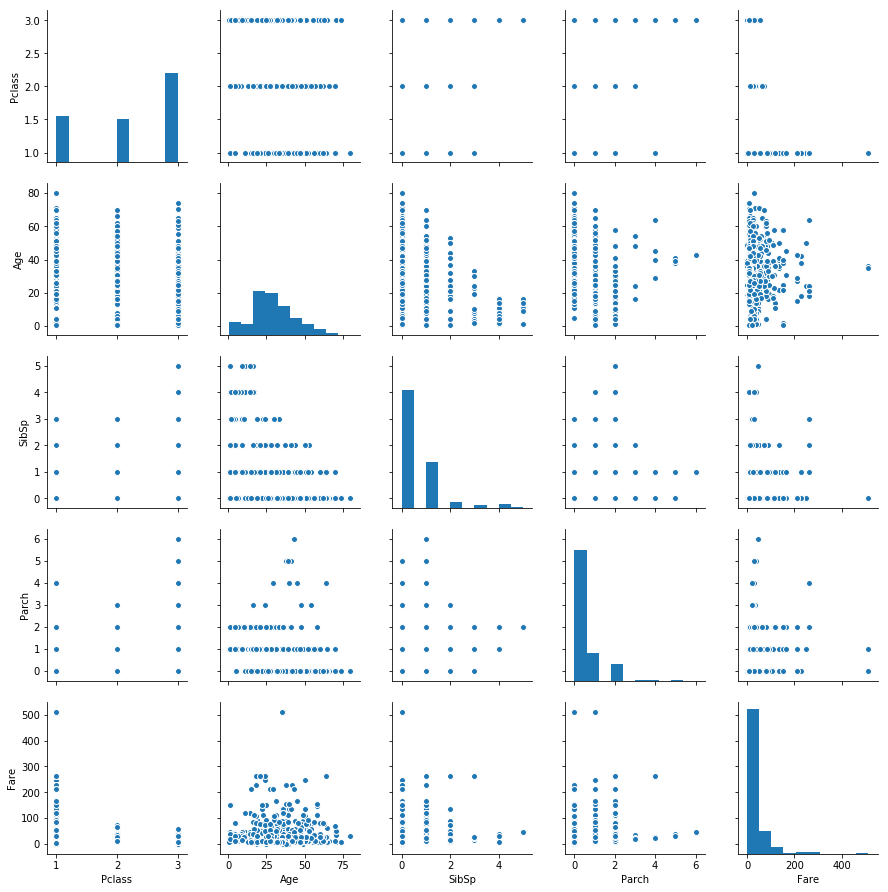

In [5]:
data_plot = data.drop(labels=['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
data_plot = data_plot.dropna()
sns.pairplot(data_plot)

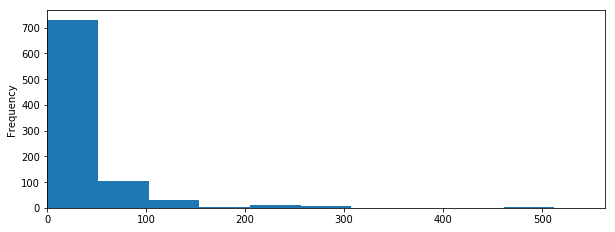

In [6]:
plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.xlim(data['Fare'].min(), data['Fare'].max()*1.1)

data['Fare'].plot(kind='hist')

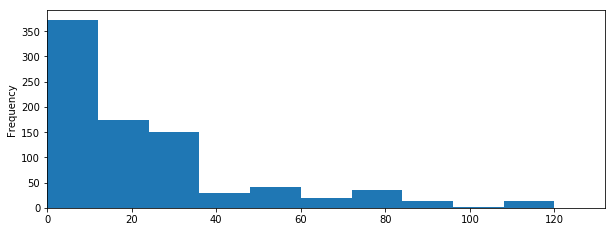

In [7]:
data = data[np.abs(data['Fare'] - data['Fare'].mean()) <= (2 * data['Fare'].std())]

plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.xlim(data['Fare'].min(), data['Fare'].max()*1.1)

data['Fare'].plot(kind='hist')

## Correlação entre os atributos

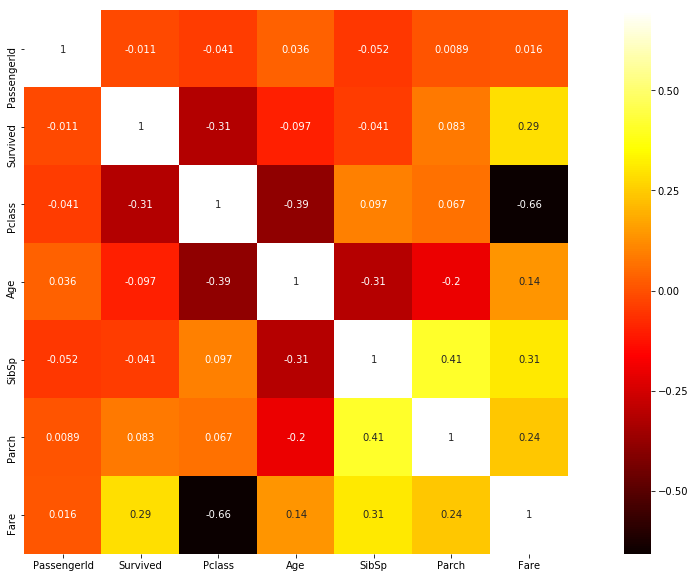

In [9]:
plt.figure(figsize=(20,10))
sns.heatmap(data.corr(), vmax=0.7,  square=True,  annot=True,  cmap="hot")

### Remoção de atributos indefinidos e dados desnecessários

In [10]:
data.drop(labels=['Name', 'Ticket', 'PassengerId'],axis=1, inplace=True)
data = data.dropna()
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
1,1,1,female,38.0,1,0,71.2833,C85,C
3,1,1,female,35.0,1,0,53.1000,C123,S
6,0,1,male,54.0,0,0,51.8625,E46,S
10,1,3,female,4.0,1,1,16.7000,G6,S
11,1,1,female,58.0,0,0,26.5500,C103,S


In [53]:
data_test = pd.read_excel('dataset/titanic3.xls')
data_test_x, data_test_y = data_test_titanic_processing(data_test)
data_test_x.head()

/Users/diogodantas/miniconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/diogodantas/miniconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/diogodantas/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:44: FutureWarning: reshape is deprecated and will raise in a subsequent release. Pl

,sex,cabin,embarked,pclass,age,sibsp,parch,fare
0,0,0.220930,2,1,0.355110,0,0,0.412503
1,1,0.424419,2,1,0.000000,1,2,0.295806
2,0,0.424419,2,1,0.013698,1,2,0.295806
3,1,0.424419,2,1,0.367755,1,2,0.295806
4,0,0.424419,2,1,0.304531,1,2,0.295806


In [54]:
data = pd.read_csv('dataset/train.csv')
data_x, data_y = data_titanic_processing(data)
data_x.head()

/Users/diogodantas/miniconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/diogodantas/miniconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/diogodantas/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Pl

,Sex,Cabin,Embarked,Pclass,Age,SibSp,Parch,Fare
0,0,0.545455,0,1,0.468892,1,0,0.139136
1,0,0.363636,2,1,0.430956,1,0,0.103644
2,1,0.886364,2,1,0.671219,0,0,0.101229
3,0,0.992424,2,3,0.038948,1,1,0.032596
4,0,0.325758,2,1,0.721801,0,0,0.051822


## Validação Cruzada

### K-fold

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_102 (Dense)            (None, 30)                270       
_________________________________________________________________
dense_103 (Dense)            (None, 30)                930       
_________________________________________________________________
dense_104 (Dense)            (None, 20)                620       
_________________________________________________________________
dense_105 (Dense)            (None, 1)                 21        
Total params: 1,913
Trainable params: 1,913
Non-trainable params: 0
_________________________________________________________________
None


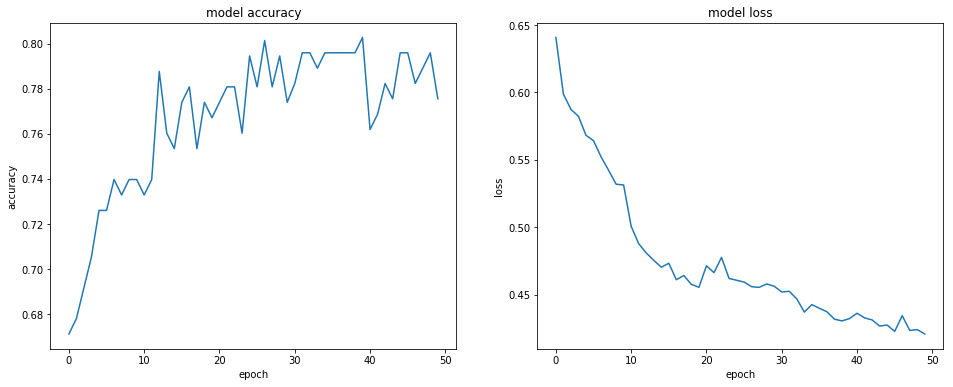

In [55]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

D_in, D_out = data_x.shape[1], data_x.shape[0]
model = Sequential()
model.add(Dense(units=D_in, activation='tanh', input_shape=(data_x.shape[1],)))
model.add(Dense(units=30, activation='tanh'))
model.add(Dense(units=30, activation='tanh'))
model.add(Dense(units=20, activation='tanh'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
print(model.summary())
acc_track = []
loss_track = []

x_train, y_train = data_x.values, data_y
x_test, y_test = data_test_x.values, data_test_y
for train, test in kfold.split(x_train, y_train):
    history = model.fit(x=x_train[train], y=y_train[train], epochs=10, batch_size=10, verbose=0, validation_data=(x_test[test], y_test[test]))

    for acc, loss in zip(history.history['acc'], history.history['loss']):
        acc_track.append(acc)
        loss_track.append(loss)

plot_acc_loss(acc_track, loss_track)

0.7888888888888889
             precision    recall  f1-score   support

          0       0.69      0.66      0.67        90
          1       0.83      0.86      0.84       180

avg / total       0.79      0.79      0.79       270



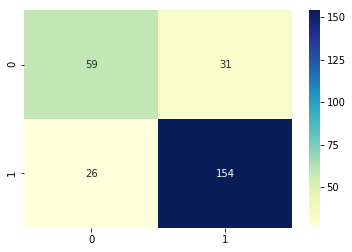

In [56]:
y_pred = model.predict(data_test_x)
y_pred = np.where(y_pred > 0.5, 1, 0)

print(accuracy_score(data_test_y, y_pred))
plt.subplot(111)
sns.heatmap(confusion_matrix(data_test_y, y_pred), annot=True, fmt='d', cmap="YlGnBu")
print(classification_report(data_test_y, y_pred))

## K-fold + Dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_107 (Dense)            (None, 30)                270       
_________________________________________________________________
dropout_31 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_32 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_109 (Dense)            (None, 20)                620       
_________________________________________________________________
dropout_33 (Dropout)         (None, 20)                0         
__________

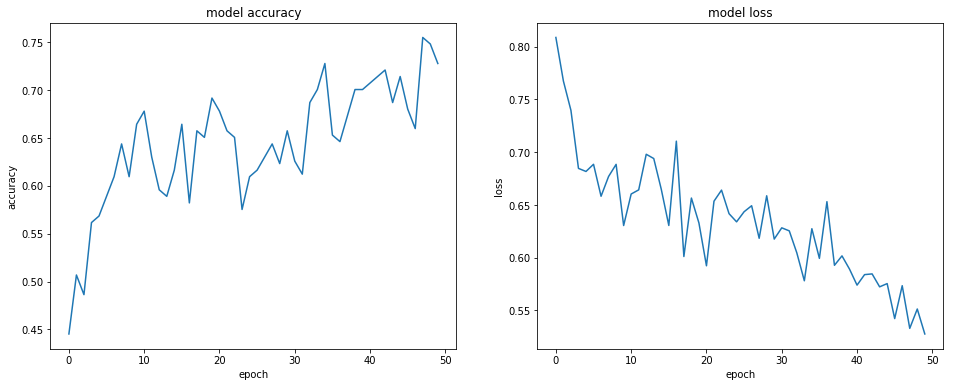

In [57]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

D_in, D_out = data_x.shape[1], data_x.shape[0]
model = Sequential()
model.add(Dense(units=D_in, activation='tanh', input_shape=(data_x.shape[1],)))
model.add(Dense(units=30, activation='tanh'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=30, activation='tanh'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=20, activation='tanh'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
print(model.summary())
acc_track = []
loss_track = []

x_train, y_train = data_x.values, data_y
x_test, y_test = data_test_x.values, data_test_y
for train, test in kfold.split(x_train, y_train):
    history = model.fit(x=x_train[train], y=y_train[train], epochs=10, batch_size=50, verbose=0, validation_data=(x_test[test], y_test[test]))

    for acc, loss in zip(history.history['acc'], history.history['loss']):
        acc_track.append(acc)
        loss_track.append(loss)

plot_acc_loss(acc_track, loss_track)

0.7148148148148148
             precision    recall  f1-score   support

          0       0.62      0.38      0.47        90
          1       0.74      0.88      0.81       180

avg / total       0.70      0.71      0.69       270



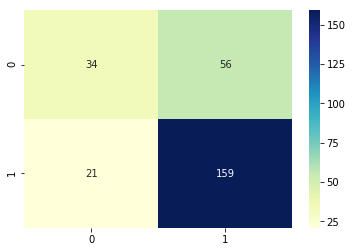

In [58]:
y_pred = model.predict(data_test_x)
y_pred = np.where(y_pred > 0.5, 1, 0)

print(accuracy_score(data_test_y, y_pred))
plt.subplot(111)
sns.heatmap(confusion_matrix(data_test_y, y_pred), annot=True, fmt='d', cmap="YlGnBu")
print(classification_report(data_test_y, y_pred))

## K-folder + BatchNormalization 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_117 (Dense)            (None, 30)                270       
_________________________________________________________________
batch_normalization_13 (Batc (None, 30)                120       
_________________________________________________________________
activation_13 (Activation)   (None, 30)                0         
_________________________________________________________________
dense_118 (Dense)            (None, 30)                930       
_________________________________________________________________
batch_normalization_14 (Batc (None, 30)                120       
_________________________________________________________________
activation_14 (Activation)   (None, 30)                0         
__________

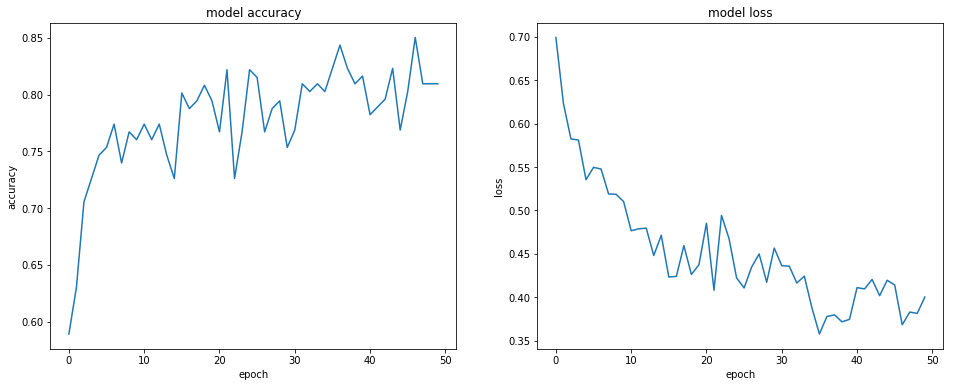

In [60]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

D_in, D_out = data_x.shape[1], data_x.shape[0]
model = Sequential()
model.add(Dense(units=D_in, activation='tanh', input_shape=(data_x.shape[1],)))
model.add(Dense(units=30))
model.add(BatchNormalization(axis=1))
model.add(Activation('tanh'))
model.add(Dense(units=30))
model.add(BatchNormalization(axis=1))
model.add(Activation('tanh'))
model.add(Dense(units=20))
model.add(BatchNormalization(axis=1))
model.add(Activation('tanh'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
print(model.summary())
acc_track = []
loss_track = []

x_train, y_train = data_x.values, data_y
x_test, y_test = data_test_x.values, data_test_y
for train, test in kfold.split(x_train, y_train):
    history = model.fit(x=x_train[train], y=y_train[train], epochs=10, batch_size=10, verbose=0, validation_data=(x_test[test], y_test[test]))

    for acc, loss in zip(history.history['acc'], history.history['loss']):
        acc_track.append(acc)
        loss_track.append(loss)

plot_acc_loss(acc_track, loss_track)

0.7888888888888889
             precision    recall  f1-score   support

          0       0.69      0.68      0.68        90
          1       0.84      0.84      0.84       180

avg / total       0.79      0.79      0.79       270



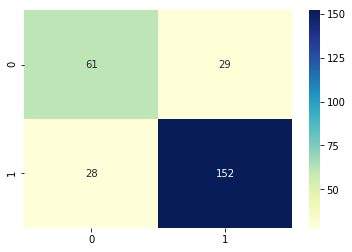

In [61]:
y_pred = model.predict(data_test_x)
y_pred = np.where(y_pred > 0.5, 1, 0)

print(accuracy_score(data_test_y, y_pred))
plt.subplot(111)
sns.heatmap(confusion_matrix(data_test_y, y_pred), annot=True, fmt='d', cmap="YlGnBu")
print(classification_report(data_test_y, y_pred))

## Holdout

### Holdout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_72 (Dense)             (None, 30)                270       
_________________________________________________________________
dense_73 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_74 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 21        
Total params: 1,913
Trainable params: 1,913
Non-trainable params: 0
_________________________________________________________________
None


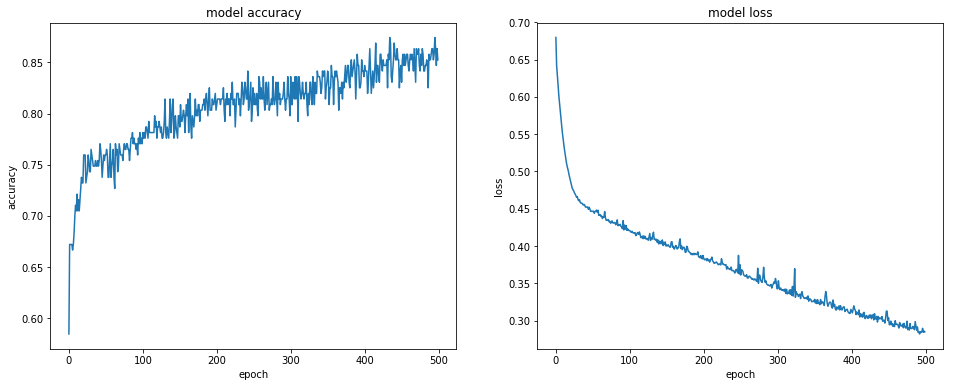

In [41]:
D_in, D_out = data_x.shape[1], data_x.shape[0]
model = Sequential()
model.add(Dense(units=D_in, activation='tanh', input_shape=(data_x.shape[1],)))
model.add(Dense(units=30, activation='tanh'))
model.add(Dense(units=30, activation='tanh'))
model.add(Dense(units=20, activation='tanh'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
print(model.summary())

history = model.fit(x=x_train, y=y_train, epochs=500, verbose=0, validation_data=(x_test, y_test))

plot_acc_loss(history.history['acc'], history.history['loss'])

0.8037037037037037
             precision    recall  f1-score   support

          0       0.69      0.74      0.72        90
          1       0.87      0.83      0.85       180

avg / total       0.81      0.80      0.81       270



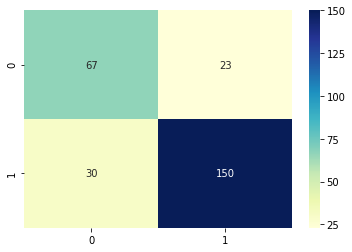

In [42]:
y_pred = model.predict(data_test_x)
y_pred = np.where(y_pred > 0.5, 1, 0)

print(accuracy_score(data_test_y, y_pred))
plt.subplot(111)
sns.heatmap(confusion_matrix(data_test_y, y_pred), annot=True, fmt='d', cmap="YlGnBu")
print(classification_report(data_test_y, y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_87 (Dense)             (None, 30)                270       
_________________________________________________________________
dropout_29 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 30)                930       
_________________________________________________________________
dropout_30 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 21        
Total para

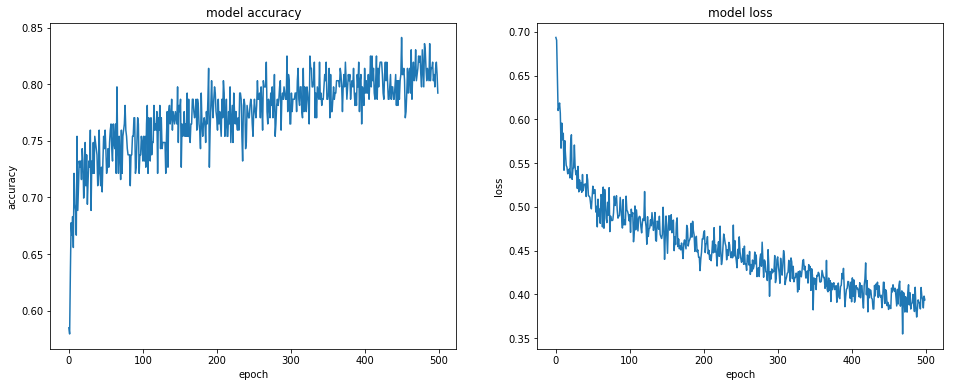

In [47]:
D_in, D_out = data_x.shape[1], data_x.shape[0]
model = Sequential()
model.add(Dense(units=D_in, activation='tanh', input_shape=(data_x.shape[1],)))
model.add(Dense(units=30, activation='tanh'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=30, activation='tanh'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=20, activation='tanh'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
print(model.summary())

history = model.fit(x=x_train, y=y_train, epochs=500, verbose=0, validation_data=(x_test, y_test))

plot_acc_loss(history.history['acc'], history.history['loss'])

0.8111111111111111
             precision    recall  f1-score   support

          0       0.72      0.70      0.71        90
          1       0.85      0.87      0.86       180

avg / total       0.81      0.81      0.81       270



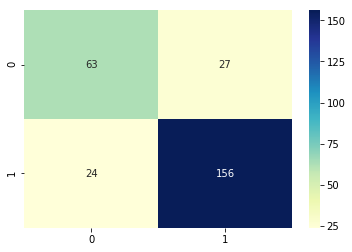

In [48]:
y_pred = model.predict(data_test_x)
y_pred = np.where(y_pred > 0.5, 1, 0)

print(accuracy_score(data_test_y, y_pred))
plt.subplot(111)
sns.heatmap(confusion_matrix(data_test_y, y_pred), annot=True, fmt='d', cmap="YlGnBu")
print(classification_report(data_test_y, y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_97 (Dense)             (None, 30)                270       
_________________________________________________________________
batch_normalization_7 (Batch (None, 30)                120       
_________________________________________________________________
activation_7 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 30)                930       
_________________________________________________________________
batch_normalization_8 (Batch (None, 30)                120       
_________________________________________________________________
activation_8 (Activation)    (None, 30)                0         
__________

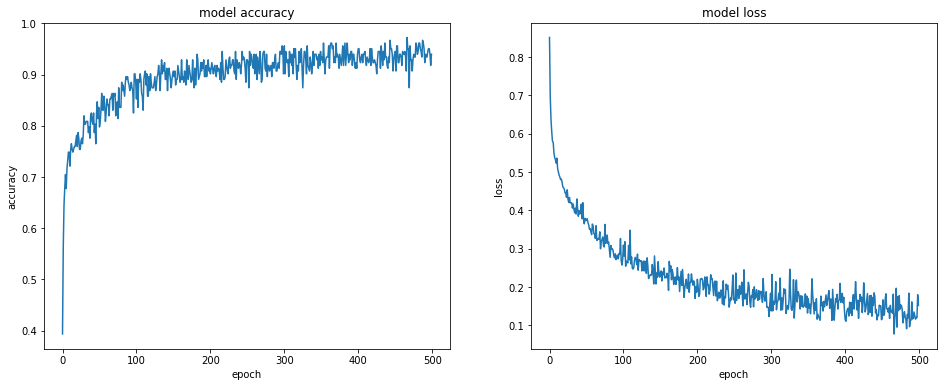

In [51]:
D_in, D_out = data_x.shape[1], data_x.shape[0]
model = Sequential()
model.add(Dense(units=D_in, activation='tanh', input_shape=(data_x.shape[1],)))
model.add(Dense(units=30))
model.add(BatchNormalization(axis=1))
model.add(Activation('tanh'))
model.add(Dense(units=30))
model.add(BatchNormalization(axis=1))
model.add(Activation('tanh'))
model.add(Dense(units=20))
model.add(BatchNormalization(axis=1))
model.add(Activation('tanh'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
print(model.summary())

history = model.fit(x=x_train, y=y_train, epochs=500, verbose=0, validation_data=(x_test, y_test))

plot_acc_loss(history.history['acc'], history.history['loss'])

0.8814814814814815
             precision    recall  f1-score   support

          0       0.82      0.82      0.82        90
          1       0.91      0.91      0.91       180

avg / total       0.88      0.88      0.88       270



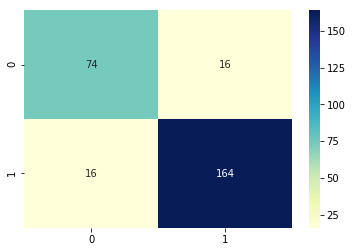

In [52]:
y_pred = model.predict(data_test_x)
y_pred = np.where(y_pred > 0.5, 1, 0)

print(accuracy_score(data_test_y, y_pred))
plt.subplot(111)
sns.heatmap(confusion_matrix(data_test_y, y_pred), annot=True, fmt='d', cmap="YlGnBu")
print(classification_report(data_test_y, y_pred))

## Resultados 

| *                   | K-Folder | Holdout |
|---------------------|----------|---------|
| S/Normalização      | 78,88%   | 80,37%  |
| Dropout             | 71,48%   | 81,11%  |
| Batch Normalization | 78,88%   | 88,14%  |